## Notebook to generate collision rate violators for any RMG job while running

In [1]:
import logging
import numpy as np
import os
import sys

In [2]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path not in sys.path:
    sys.path.append(rmg_path)
sys.path

import rmgpy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmgobject import RMGObject, expand_to_dict, recursive_make_object

print(f"RMG-Py Version {rmgpy.__version__}")
print(rmgpy.__file__)

RDKit WARNING: [00:26:39] Enabling RDKit 2019.09.1 jupyter extensions


RMG-Py Version 3.0.0
/Users/rwest/Code/RMG-Py/rmgpy/__init__.py


In [3]:
chemkin_file = '../RMG-model/chemkin/chem_annotated-gas.inp'
chemkin_folder = os.path.split(chemkin_file)[0]
species_dictionary_file = os.path.join(chemkin_folder, 'species_dictionary.txt')
transport_file = os.path.join(chemkin_folder, 'tran.dat')

In [4]:
species, reactions = rmgpy.chemkin.load_chemkin_file(
                    chemkin_file, species_dictionary_file,transport_path=transport_file,
                    check_duplicates=False, use_chemkin_names=True,read_comments=True)



In [5]:
species_dict = {rmgpy.chemkin.get_species_identifier(s): s for s in species}
species_dict.keys()

dict_keys(['Ne', 'H4N2O2(2)', 'NH2OH(3)', 'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)', 'O2(8)', 'NO2(9)', 'NO(10)', 'N2O(11)', 'CO2(12)', 'H2(13)', 'CO(14)', 'CH4(15)', 'C2H6(16)', 'CH2O(17)', 'CH3(18)', 'C3H8(19)', 'H(20)', 'C2H5(21)', 'HCO(22)', 'CH3CHO(23)', 'OH(24)', 'C2H4(25)', 'O(36)', 'HO2(39)', 'H2O2(40)', 'CH2OH(45)', 'CH3O(46)', 'NH2(85)', 'NH3(86)', 'NH(87)', 'HNO(88)', 'H2NO(89)', 'HONO(93)', 'HNOH(94)', 'HNO2(95)', 'NO3(96)', 'N2H2(97)', 'N2H3(99)', 'N2H4(100)', 'H3N2O(193)', 'S(194)', 'H2NO2(195)', 'S(196)', 'S(197)', 'H2NO3(252)', 'NOHJJ(255)', 'ONCDO(272)', 'H2NO4(293)', 'HNO(501)', 'H2N2O(502)', 'H2N2O(503)', 'NNDO(506)', 'H3N2O(507)', 'H3N2O(508)', 'H4N2O(514)', 'NNO(515)', 'S(566)', 'H2N2(575)', 'S(650)', 'H2NO5(674)', 'H2NO3(714)', 'H2N2(742)', 'NH3NH(748)', 'H2NO2(813)', 'H3NO3(918)', 'ONCO(964)', 'NOO(1018)', 'NOON(1048)', 'S(1130)', 'S(1375)', 'S(1376)', 'S(1377)', 'S(2074)'])

In [6]:
def check_collision_limit_violation(self, t_min, t_max, p_min, p_max):
        """
        Warn if a core reaction violates the collision limit rate in either the forward or reverse direction
        at the relevant extreme T/P conditions. Assuming a monotonic behaviour of the kinetics.
        Returns a list with the reaction object and the direction in which the violation was detected.
        """
        conditions = [[t_min, p_min]]
        if t_min != t_max:
            conditions.append([t_max, p_min])
        if self.kinetics.is_pressure_dependent() and p_max != p_min:
            conditions.append([t_min, p_max])
            if t_min != t_max:
                conditions.append([t_max, p_max])
        logging.debug("Checking whether reaction {0} violates the collision rate limit...".format(self))
        violator_list = []
        kf_list = []
        kr_list = []
        collision_limit_f = []
        collision_limit_r = []
        for condition in conditions:
            if len(self.reactants) >= 2:
                try:
                    collision_limit_f.append(self.calculate_coll_limit(temp=condition[0], reverse=False))
                except ValueError:
                    continue
                else:
                    kf_list.append(self.get_rate_coefficient(condition[0], condition[1]))
            if len(self.products) >= 2:
                try:
                    collision_limit_r.append(self.calculate_coll_limit(temp=condition[0], reverse=True))
                except ValueError:
                    continue
                else:
                    kr_list.append(self.generate_reverse_rate_coefficient().get_rate_coefficient(condition[0], condition[1]))
        if len(self.reactants) >= 2:
            for i, k in enumerate(kf_list):
                if k > collision_limit_f[i]:
                    ratio = k / collision_limit_f[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'forward', ratio, condition])
        if len(self.products) >= 2:
            for i, k in enumerate(kr_list):
                if k > collision_limit_r[i]:
                    ratio = k / collision_limit_r[i]
                    condition = '{0} K, {1:.1f} bar'.format(conditions[i][0], conditions[i][1] / 1e5)
                    violator_list.append([self, 'reverse', ratio, condition])
        return violator_list

In [7]:
import numpy as np
np.linalg.LinAlgError

numpy.linalg.linalg.LinAlgError

In [8]:
violators = []
for r in reactions:
    try:
        v = check_collision_limit_violation(r, 150+273,1000, 1e5, 30e5)
    except np.linalg.LinAlgError:
        print(f"LinAlgError checking {r}")
    if v:
        print(r)
        violators.extend(v)

NH2(85) + NH2(85) <=> H(20) + N2H3(99)
NO(10) + NH2(85) <=> NNDO(506)
H3N2O(193) + CH2OH(45) <=> S(1375)
HNOH(94) + CH2OH(45) <=> ONCO(964)
O2(8) + HNOH(94) <=> H2NO3(714)
HNOH(94) + HCO(22) <=> ONCDO(272)
H3N2O(193) + C2H5(21) <=> H4N2O(514) + C2H4(25)
H3N2O(193) + HCO(22) <=> H4N2O(514) + CO(14)
H3N2O(193) + H3N2O(193) <=> H2N2O(503) + H4N2O(514)
H3N2O(193) + H3N2O(193) <=> NNDO(506) + H4N2O(514)
H2NO3(252) + H3N2O(193) <=> HNO3(4) + H4N2O(514)
H3N2O(193) + CH2OH(45) <=> H4N2O(514) + CH2O(17)
H3N2O(193) + CH3O(46) <=> H4N2O(514) + CH2O(17)
H3N2O(507) + H3N2O(193) <=> NNDO(506) + H4N2O(514)
HNOH(94) + H3N2O(193) <=> HNO(88) + H4N2O(514)
H2NO(89) + H3N2O(193) <=> HNO(88) + H4N2O(514)
NOHJJ(255) + H3N2O(193) <=> NO(10) + H4N2O(514)
H3N2O(508) + H3N2O(193) <=> H2N2O(503) + H4N2O(514)
H(20) + HO2(39) <=> H2O2(40)
H2N2O(502) + CH2OH(45) <=> S(1377)
H2NO3(252) + S(1377) <=> HNO3(4) + S(1375)
NOHJJ(255) + S(1377) <=> NO(10) + S(1375)
HCO(22) + S(1377) <=> CO(14) + S(1375)
CH2OH(45) + S(1377)

In [9]:
from rmgpy.data.kinetics import TemplateReaction, LibraryReaction
from rmgpy.rmg.pdep import PDepReaction

In [10]:
violators.sort(key = lambda violator: -violator[2])

Text(0.5, 0, 'reaction index (of 1573 total)')

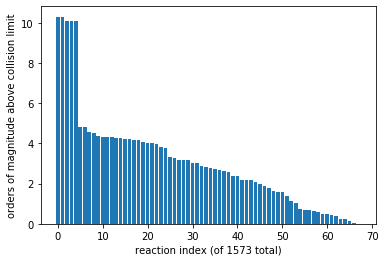

In [11]:
ratios = [np.log10(violator[2]) for violator in violators]
from matplotlib import pyplot as plt
plt.bar(np.arange(len(ratios)), ratios)
plt.ylabel("orders of magnitude above collision limit")
plt.xlabel(f"reaction index (of {len(reactions)} total)")

In [12]:
len(ratios), len(reactions)

(68, 1573)

In [13]:
for violator in violators[:100]:
    rxn_string = str(violator[0])
    direction = {'forward':'=>','reverse':'<='}[violator[1]]
    ratio = violator[2]
    print(f"{rxn_string.replace('<=>',direction) :48s}  {ratio :.1g}")

HNOH(94) + CH2OH(45) => ONCO(964)                 2e+10
HNOH(94) + HCO(22) => ONCDO(272)                  2e+10
H3N2O(193) + CH2OH(45) => S(1375)                 1e+10
H2N2O(502) + CH2OH(45) => S(1377)                 1e+10
H2N2O(502) + CH2OH(45) => S(1376)                 1e+10
H3N2O(193) + H3N2O(193) <= H2N2O(503) + H4N2O(514)  6e+04
H3N2O(193) + S(1377) <= H2N2O(503) + S(1375)      6e+04
N2H3(99) + H3N2O(193) <= N2H2(97) + H4N2O(514)    4e+04
N2H3(99) + S(1377) <= N2H2(97) + S(1375)          3e+04
H3N2O(193) + CH2OH(45) <= H4N2O(514) + CH2O(17)   2e+04
CH2OH(45) + S(1377) <= CH2O(17) + S(1375)         2e+04
H3N2O(193) + C2H5(21) <= H4N2O(514) + C2H4(25)    2e+04
H2NO2(813) + H3N2O(193) <= HNO2(95) + H4N2O(514)  2e+04
H2NO2(813) + S(1377) <= HNO2(95) + S(1375)        2e+04
S(1377) + C2H5(21) <= S(1375) + C2H4(25)          2e+04
HNOH(94) + H3N2O(193) <= HNO(88) + H4N2O(514)     2e+04
H2NO(89) + H3N2O(193) <= HNO(88) + H4N2O(514)     2e+04
HNOH(94) + S(1377) <= HNO(88) + S(1375)       

In [14]:
from collections import Counter
import re

In [15]:
families = Counter()
templates = Counter()
rate_rules = Counter()
problem_species = Counter()
for violator in violators:
    rxn_string = str(violator[0])
    kinetics = violator[0].kinetics
    comment = ''
    if isinstance(violator[0], TemplateReaction):
        comment = violator[0].kinetics.comment
        violator[0].kinetics.comment = ''  # the comment is printed better when outside of the object
    if isinstance(violator[0], LibraryReaction):
        comment = 'Kinetic library: {0}'.format(violator[0].library)
    if isinstance(violator[0], PDepReaction):
        comment = 'Network #{0}'.format(violator[0].network)
    direction = violator[1]
    ratio = violator[2]
    condition = violator[3]
    
    problem_species.update(violator[0].reactants)
    problem_species.update(violator[0].products)
    
    m = re.search('family: (.*)', comment)
    if m:
        families[m.group(1)] += 1
    n = re.search('rate rule (.*)', comment)
    if n:
        rate_rules[m.group(1) + n.group(1)] += 1
    n = re.search('using template (\S+)', comment)
    if n:
        templates[m.group(1) + n.group(1)] += 1
    
    if ratio < 5:
        continue # only print the big ones!
        
    print('{0}\n{1}\n{2}\nDirection: {3}\nViolation factor: {4:.2g}\n'
                      'Violation condition: {5}\n\n'.format(rxn_string, kinetics, comment, direction,
                                                            ratio, condition))
    if isinstance(violator[0], TemplateReaction):
        # although this is the end of the run, restore the original comment
        violator[0].kinetics.comment = comment

HNOH(94) + CH2OH(45) <=> ONCO(964)
Arrhenius(A=(6.89518e+79,'cm^3/(mol*s)'), n=-21.017, Ea=(0,'kcal/mol'), T0=(1,'K'))
BM rule fitted to 2 training reactions at node Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C Total Standard Deviation in ln(k): 11.5401827615
Exact match found for rate rule [Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]
Euclidian distance = 0
family: R_Recombination
Direction: forward
Violation factor: 2e+10
Violation condition: 423 K, 1.0 bar


HNOH(94) + HCO(22) <=> ONCDO(272)
Arrhenius(A=(6.89518e+79,'cm^3/(mol*s)'), n=-21.017, Ea=(0,'kcal/mol'), T0=(1,'K'))
BM rule fitted to 2 training reactions at node Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C Total Standard Deviation in ln(k): 11.5401827615
Exact match found for rate rule [Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]
Euclidian distance = 0
family: R_Recombination
Direction: forward
Violation factor: 1.9e+10
Violation condition: 423 K, 1.0 bar


H3N2O(193) + CH2OH(45) <=> S(1375)
Arrhenius(A=(6.89518e+79,'cm^3

In [16]:
families.most_common(10)

[('Disproportionation', 46),
 ('R_Recombination', 13),
 ('CO_Disproportionation', 2),
 ('Birad_R_Recombination', 2)]

In [17]:
# This is what was used
templates.most_common(10)

[('Disproportionation[Y_rad;O_Nrad]', 14),
 ('Disproportionation[Y_rad;N3s/H2_s_Nrad]', 8),
 ('Disproportionation[Y_rad;N3H_s_Rrad]', 6),
 ('Disproportionation[Y_rad;Cmethyl_Csrad]', 4),
 ('Disproportionation[Y_rad;N3s/H2_s_Orad]', 4),
 ('Disproportionation[Y_rad;O_Csrad]', 2),
 ('Disproportionation[Y_rad;NH_s_Rrad]', 2),
 ('Disproportionation[Y_rad;Cmethyl_Orad]', 2),
 ('Disproportionation[Y_rad;XH_s_Rbirad]', 2),
 ('CO_Disproportionation[Y_rad;HCO]', 2)]

In [18]:
# This is what it was trying to use
rate_rules.most_common(10)

[('Disproportionation[N5s_rad;O_Nrad]', 14),
 ('R_Recombination[Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0_2R->C]', 10),
 ('Disproportionation[N5s_rad;N3s/H2_s_Nrad]', 8),
 ('Disproportionation[N5s_rad;N3s/H/NonDe_s_Rrad]', 6),
 ('Disproportionation[N5s_rad;Cmethyl_Csrad]', 4),
 ('Disproportionation[N5s_rad;N3s/H2_s_Orad]', 4),
 ('Disproportionation[N5s_rad;O_Csrad]', 2),
 ('Disproportionation[N5s_rad;N5H_s_Rrad]', 2),
 ('R_Recombination[Root_N-1R->H_1CNOS->N_Ext-2R-R_3R!H-u0]', 2),
 ('Disproportionation[N5s_rad;Cmethyl_Orad]', 2)]

In [19]:
# Most common species
for s,n in problem_species.most_common(20):
    print(f"{str(s):10s}  {n:3d}  {s.thermo.comment[:40]}")

H3N2O(193)   33  Thermo library: Nitrogen_G4
S(1375)      25  Thermo group additivity estimation: grou
S(1377)      25  Thermo group additivity estimation: grou
H4N2O(514)   23  Thermo group additivity estimation: grou
HNOH(94)     10  Thermo library: NOx2018
CH2OH(45)    10  Thermo library: NOx2018
HNO(88)      10  Thermo library: NOx2018
H2N2O(503)    8  Thermo library: Nitrogen_G4
NNDO(506)     8  Thermo library: Nitrogen_G4
NH2(85)       7  Thermo library: primaryThermoLibrary
N2H3(99)      6  Thermo library: NOx2018
H2NO2(813)    6  Thermo library: Nitrogen_G4
H2NO(89)      6  Thermo library: NOx2018
HCO(22)       4  Thermo library: NOx2018
H2N2O(502)    4  Thermo library: Nitrogen_G4 + radical(O2
N2H2(97)      4  Thermo library: NOx2018
CH2O(17)      4  Thermo library: NOx2018
C2H5(21)      4  Thermo library: NOx2018
C2H4(25)      4  Thermo library: NOx2018
HNO2(95)      4  Thermo library: NOx2018


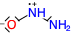

H3N2O(193)
multiplicity 2
1 O u0 p3 c-1 {2,S}
2 N u1 p0 c+1 {1,S} {3,S} {4,S}
3 N u0 p1 c0 {2,S} {5,S} {6,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {3,S}
6 H u0 p0 c0 {3,S}

Thermo library: Nitrogen_G4
--------------------------------------------------------------------------------


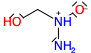

S(1375)
1  O u0 p2 c0 {5,S} {11,S}
2  O u0 p3 c-1 {3,S}
3  N u0 p0 c+1 {2,S} {4,S} {5,S} {6,S}
4  N u0 p1 c0 {3,S} {9,S} {10,S}
5  C u0 p0 c0 {1,S} {3,S} {7,S} {8,S}
6  H u0 p0 c0 {3,S}
7  H u0 p0 c0 {5,S}
8  H u0 p0 c0 {5,S}
9  H u0 p0 c0 {4,S}
10 H u0 p0 c0 {4,S}
11 H u0 p0 c0 {1,S}

Thermo group additivity estimation: group(O2s-CsH) + group(O2s-CsCs) + group(N) + group(N3s-N) + group(Cs-CsCsCsCs)
--------------------------------------------------------------------------------


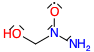

S(1377)
multiplicity 2
1  O u0 p2 c0 {5,S} {10,S}
2  O u1 p2 c0 {3,S}
3  N u0 p1 c0 {2,S} {4,S} {5,S}
4  N u0 p1 c0 {3,S} {8,S} {9,S}
5  C u0 p0 c0 {1,S} {3,S} {6,S} {7,S}
6  H u0 p0 c0 {5,S}
7  H u0 p0 c0 {5,S}
8  H u0 p0 c0 {4,S}
9  H u0 p0 c0 {4,S}
10 H u0 p0 c0 {1,S}

Thermo group additivity estimation: group(O2s-CsH) + group(O2s-N) + group(N3s-N) + group(N3s-N3sHH) + group(Cs-CsCsCsCs) + radical(O2sJ-N3s_459)
--------------------------------------------------------------------------------


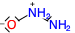

H4N2O(514)
1 O u0 p3 c-1 {2,S}
2 N u0 p0 c+1 {1,S} {3,S} {4,S} {5,S}
3 N u0 p1 c0 {2,S} {6,S} {7,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}
6 H u0 p0 c0 {3,S}
7 H u0 p0 c0 {3,S}

Thermo group additivity estimation: group(O2s-CsCs) + group(N) + group(N3s-N)
--------------------------------------------------------------------------------


HNOH(94)
multiplicity 2
1 O u0 p2 c0 {2,S} {4,S}
2 N u1 p1 c0 {1,S} {3,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {1,S}

Thermo library: NOx2018
--------------------------------------------------------------------------------


CH2OH(45)
multiplicity 2
1 O u0 p2 c0 {2,S} {5,S}
2 C u1 p0 c0 {1,S} {3,S} {4,S}
3 H u0 p0 c0 {2,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {1,S}

Thermo library: NOx2018
--------------------------------------------------------------------------------


HNO(88)
1 O u0 p2 c0 {2,D}
2 N u0 p1 c0 {1,D} {3,S}
3 H u0 p0 c0 {2,S}

Thermo library: NOx2018
--------------------------------------------------------------------------------


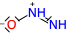

H2N2O(503)
1 O u0 p3 c-1 {2,S}
2 N u0 p0 c+1 {1,S} {3,D} {4,S}
3 N u0 p1 c0 {2,D} {5,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {3,S}

Thermo library: Nitrogen_G4
--------------------------------------------------------------------------------


NNDO(506)
1 O u0 p2 c0 {3,D}
2 N u0 p1 c0 {3,S} {4,S} {5,S}
3 N u0 p1 c0 {1,D} {2,S}
4 H u0 p0 c0 {2,S}
5 H u0 p0 c0 {2,S}

Thermo library: Nitrogen_G4
--------------------------------------------------------------------------------


NH2(85)
multiplicity 2
1 N u1 p1 c0 {2,S} {3,S}
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}

Thermo library: primaryThermoLibrary
--------------------------------------------------------------------------------


In [20]:
for s,n in problem_species.most_common(10):
    display(s)
    print(s)
    print(s.molecule[0].to_adjacency_list())
    print(s.thermo.comment)
    print('-'*80)